In [1]:

import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
from shapey import Box
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
#path_data = '/users/caganze/research/stellarstreams/data/rotating/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#potential and hamiltonian
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)

galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)


#NSAMPLES_STREAM={27.15: 260, 28.54:1300}

In [3]:
#functions
def get_background(center, dist_range='10_20', dmod=25.0, FeH_phot=-1., mag_limit=27.15):
    
    #compute distance and scale Roman FOV
    d_M31=10**(dmod/5+1)*u.pc.to(u.kpc)
    kpc_conversion = np.pi * d_M31 / 180.
    scaled_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= (10*u.arcmin.to(u.degree)*u.degree)*(kpc_conversion /u.degree)
    print (kpc_conversion)
    
    
    outfile = isochrone_path+'/WFIfilters_extendedIsochrones_allbands_dmod{:.2f}_maglimit{}_M31_{}kpc.txt'.format(dmod,  mag_limit, dist_range)
    bckgd=ascii.read(outfile).to_pandas()
    bckgd=(bckgd[np.logical_and(bckgd.Z < mag_limit, bckgd.FeH_phot<FeH_phot)]).reset_index(drop=True)
    
    print (np.nanmedian(kpc_conversion*bckgd.RA.values))
    
    shift_x=np.nanmedian(kpc_conversion*bckgd.RA.values)-center[0]
    shift_y=np.nanmedian(kpc_conversion*bckgd.DEC.values)-center[1]
    
    bx_center=(center[-1], center[0])
    bx=roman_fov(center, scaled_fov.value, scaled_fov.value)
    bx.color='none'
    bx.edgecolor='r'
    df=pd.DataFrame()
    bckgd['x_coord']=kpc_conversion*bckgd.RA.values-shift_x
    bckgd['y_coord']=kpc_conversion*bckgd.DEC.values-shift_y
    
    return {'box': bx, 'data': bckgd.iloc[bx.select(bckgd[['x_coord', 'y_coord']]).index], 
           'arcmin':     scaled_arcmin, 'fov': scaled_fov}


def resample_stream(xy, mag_limit, d_mod, gap_center, center, box):
    
    key='mlimit{} dmod{:.2f}'.format(mag_limit, d_mod)
    N=int(round(NUM_STARS[key]))
    
    #crop [THIS IS CHEATING]
    
    x0=xy[0]-(gap_center[0]-center[0])
    y0=xy[1]-(gap_center[1]-center[1])

    
    choose=np.random.choice(np.arange(len(x0)), N)
    
    selected=box.select(np.array([x0[choose], y0[choose]]))
    x=selected[0]
    y=selected[1]
    
    return  [x,  y]
                    
        
def transform_to_phi_coordinates(st, end_points=None):
    stream_p=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.z.unit,
                          vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    #transform to stream coordinate frame 
    stream_c = stream_p.to_coord_frame(astro_coord.ICRS)
    
    if end_points is  None:
        min_ra_id= np.argmin(stream_c.ra.degree)
        max_ra_id=np.argmax(stream_c.ra.degree)
        
        end_points=astro_coord.SkyCoord(ra=[stream_c.ra.degree[min_ra_id], \
                                           stream_c.ra.degree[max_ra_id]]*u.deg,
                            dec=[stream_c.dec.degree[min_ra_id], \
                                           stream_c.dec.degree[max_ra_id]]*u.deg)

    fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
    return {'icrs': stream_c, 'great_circ': stream_c.transform_to(fr)}

def roman_fov(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    #b._data=[ra,## dec]
    return b

#length and ith of the stream 
#procedure 
def compute_width(m, vc, Rgc):
    return Rgc*((m*G/(vc**2*Rgc))**(1/3))

def compute_physical_length(Rgc, m, vc, t):
    return  ((m*vc/Rgc)**(1/3))*t

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def evolve_stream_in_time(st, time, dt=1*u.Myr, progenitor=False):
    time_dict={'t1': 0*u.Myr, 't2': time, 'dt': dt}
    #make a phase space position objec
    stpos=None
    if progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x.value, st.y.value, st.z.value])*st.x.unit,
                              vel=np.array([st.v_x.value, st.v_y.value, st.v_z.value])*st.v_z.unit)
    if not progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.x.unit,
                              vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(stpos,  **time_dict)
    
    #integrate in time
    new_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                       z= final_stream_orbit.z[-1], v_x=final_stream_orbit.v_x[-1],\
                       v_y=final_stream_orbit.v_y[-1], v_z=final_stream_orbit.v_z[-1],\
                       frame=galcen_frame)
    return new_stream_coord

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)


def make_density_plot(values, ax, cmap=plt.cm.coolwarm, bins=100, hist=False):
    if not hist:
        kernel = stats.gaussian_kde(values)
        x, y=np.meshgrid(np.linspace(values[0].min()-0.9, values[0].max(), bins), \
                         np.linspace(values[1].min()-0.9, values[1].max(), bins))
        positions = np.vstack([x.ravel(), y.ravel()])
        Z = np.reshape(kernel(positions).T, x.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax.scatter(positions[0], positions[1], c=kernel(positions), cmap=cmap)
    if hist:
        _= ax.hist2d(values[0], values[1], cmap=cmap, bins=bins)

In [4]:
vhalo=50
mstream=1
mhalo='5.00e+06'
gap_center= (6, 14)

#k= list(STREAMS.keys())[0]
#filename='mass_1_times_pal5_rgc10_mhalo1.00e+08_vhalo50_*'
#filename='test*'
#filename='rotating_Msub1.00e+06_ImpactVrz35*'


dist='50_60'
d=([0.5, 0.6, 0.77, 0.8, 0.9, 1.0, 2., 2.5, 3., 3.5, 4., 5.])*u.Mpc
dmods=5*np.log10(d.to(u.pc)/(10*u.pc)).value
mag_limit=27.15

NUM_STARS=pd.read_pickle(isochrone_path+'/number_of_stars_pal5.pkl')

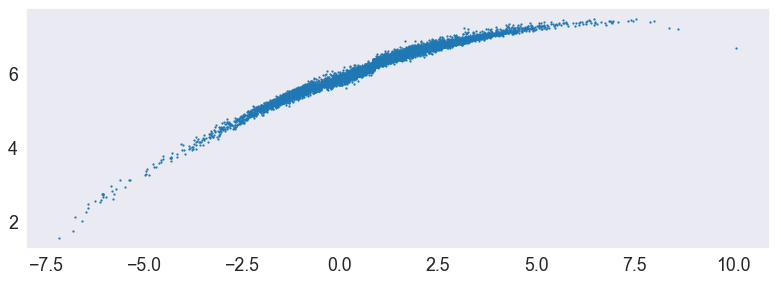

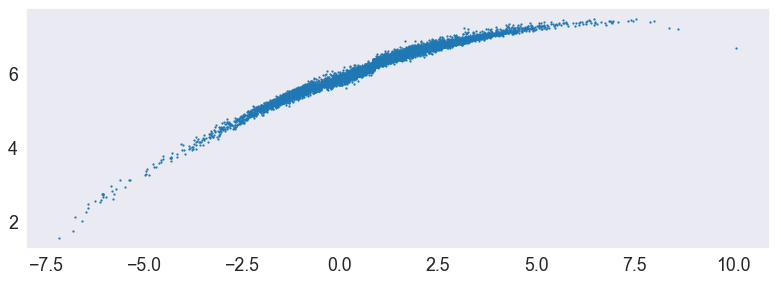

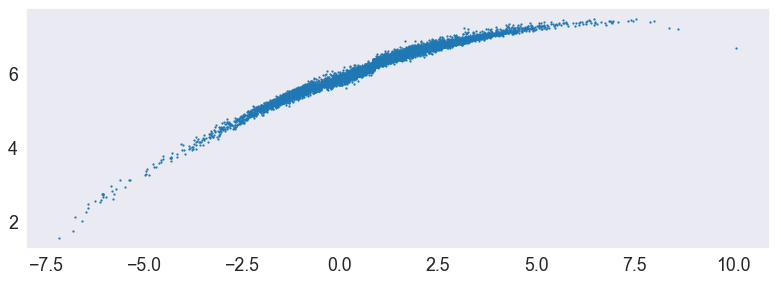

In [46]:
STREAMS={'10_20': None, 
         '30_40': None,
        '50_60': None}

#stream
#%matplotlib notebook
k= list(STREAMS.keys())[0]
#filename='mass_1_times_pal5_rgc10_mhalo1.00e+08_vhalo50_*'
#filename='test*'
#filename='rotating_Msub1.00e+06_ImpactVrz35*'
#filename='simpler_rgc10_direct_nbody1.00e+06*'
filename='mass_1_times_pal5_rgc10_mhalo5.00e+06*'
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st0=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(st0.y, st0.x, s=1)

#if False:
k= list(STREAMS.keys())[1]
#filename='mass_1_times_pal5_rgc30_mhalo1.00e+08_vhalo10_*'
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(st.y, st.x, s=1)

k= list(STREAMS.keys())[-1]
#filename='mass_1_times_pal5_rgc50_mhalo1.00e+08_vhalo10_*'
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
#p=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog'][0]
STREAMS[k]= st0
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(st.y, st.x, s=1)
#ax.scatter(p.x, p.z, s=100)


In [47]:
#gap_center=(16, -41.5)
#gap_center=(0, 50)

In [42]:
#visualize gap in time steps
#for t in np.linspace(0.1, 5, 20):
#    evolved_st= evolve_stream_in_time(st, t*u.Gyr)
#    fig, ax=plt.subplots(figsize=(12, 4))
#    ax.scatter(evolved_st.y, evolved_st.z, s=1, alpha=0.1)
#    ax.set(title='Time {}'.format(t*u.Gyr+200*u.Myr))

8.726646259971647
41.421590798295064
10.471975511965983
49.70925827970866
13.439035240356349
63.749136665501396
13.962634015954642
66.20974760328687
15.707963267948978
74.49071151614788
17.453292519943293
82.87266444631057
34.90658503988659
165.40876205318747
43.63323129985823
207.08620701964884
52.359877559829904
248.102091693353
61.08652381980154
289.5016458442685
69.8131700797732
330.5266749055717
87.26646259971646
413.5648282398373


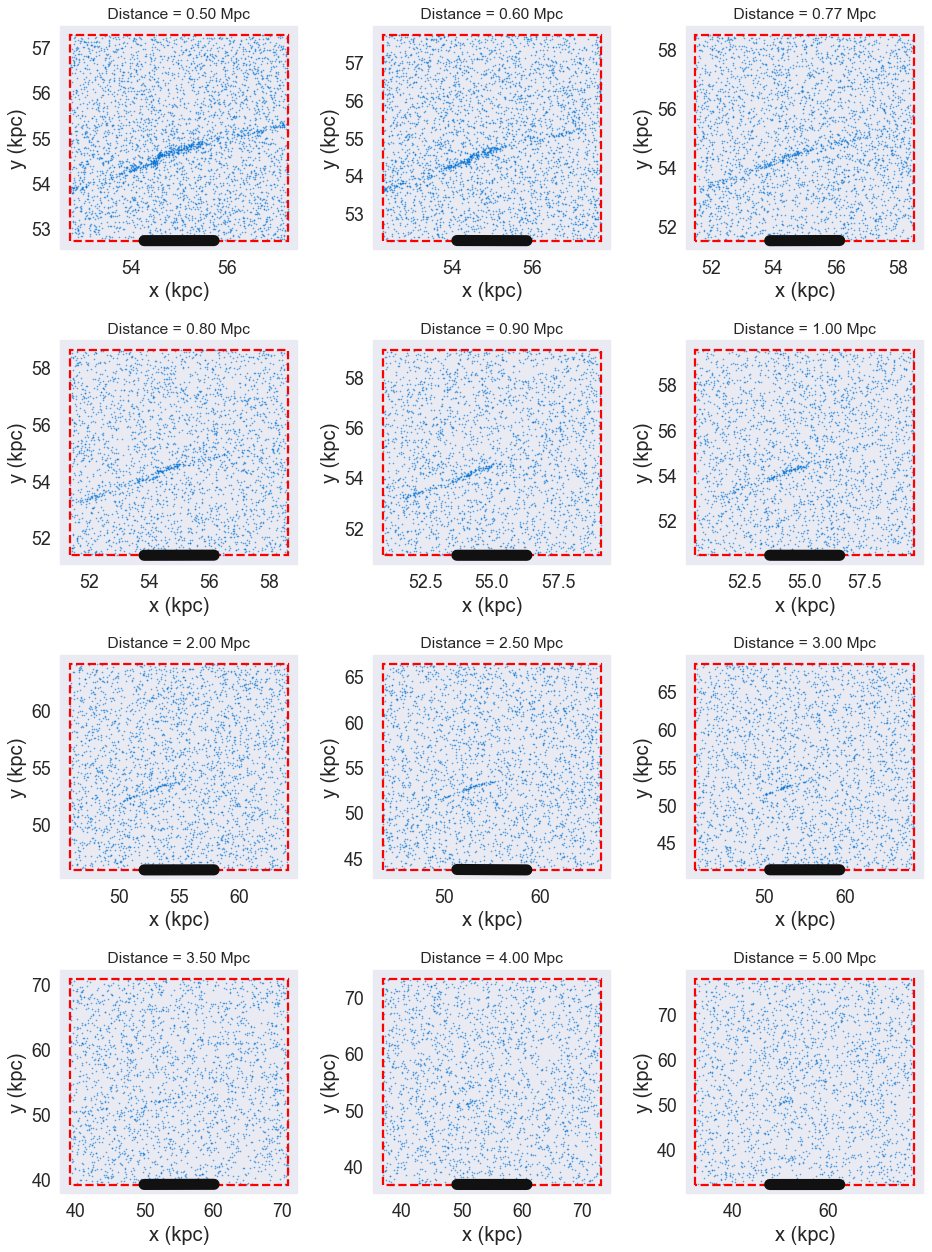

In [49]:
images={}

fig, ax=plt.subplots(figsize=(12, 8*2), ncols=3, nrows=4)

for dmod, a in zip(dmods, np.concatenate(ax)):
    
    #get backgrounds
    
    rgc=np.nanmedian(np.array(dist.split('_')).astype(float))
    
    center=np.array([0, 0 ])+rgc
    
    vals=get_background(center, dist_range=dist, dmod=dmod, FeH_phot=-1., mag_limit=mag_limit)
    
    scaled_arcmin= vals['arcmin']
    
    

    a.plot((center[0]-scaled_arcmin.value/2, center[0]+scaled_arcmin.value/2),
           (vals['data'].x_coord.min(), vals['data'].y_coord.min()), lw=10, c='#111111', linestyle='-')
    

    b=vals['box']
    b.alpha=1.
    b.plot(ax=a)
    
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    a.scatter(vals['data'].x_coord, vals['data'].y_coord, s=0.1, color='#0074D9')
    
    evolved_st= STREAMS[dist]
    
    gap_center=(np.nanmedian( evolved_st.y.value), np.nanmedian(evolved_st.x.value))
    
    rst= resample_stream([evolved_st.y.value, evolved_st.x.value], \
                         mag_limit, dmod, gap_center, vals['box'].center, vals['box'])

    
    a.scatter(rst[0], rst[1],  s=0.1, color='#0074D9')
    
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Distance = {:.2f} Mpc '.format(  d_M31), fontsize=14)
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)
    

    
    #append values to one image
    images.update({'{:.2f}'.format(dmod): [np.concatenate([vals['data'].x_coord,rst[0]]), \
                                           np.concatenate([vals['data'].y_coord,rst[1]])]})
    

plt.tight_layout()

plt.savefig(path_plot+'/gaps_at_distance_mag{}.jpeg'.format(mag_limit), rasterized=True)

In [50]:
#iimplement a a KL divergence to measure how different the 
from scipy.signal import find_peaks
def kernel_density(x, bw_method=0.01):
    return stats.gaussian_kde(x, bw_method= bw_method)


def return_estimated_2d_kernel(x, y, bw_method=0.1, xmin=0, xmax=0, ymin=0, ymax=0):
    values = np.vstack([x, y])
    k=kernel_density(values, bw_method=bw_method)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid = np.vstack([X.ravel(), Y.ravel()])
    kde=k(grid)
    Z = np.reshape(kde.T, X.shape)
    return { 'grid': grid, 'kde':Z}


def return_estimated_1d_kernel(x,bw_method=0.1, xmin=0, xmax=0):
    k=kernel_density(x, bw_method=bw_method)
    grid = np.linspace(xmin, xmax, 5000)
    kde=k(grid)
    return { 'grid': grid, 'kde':kde, 'estimator': k}

def compute_kl_divergence(p, q):
    return np.nansum(p*np.log(p/q))


def estimate_kl_divergence_iterative(x, bws=[0.1, 0.6], search_region=None):
    
    if search_region is None:
        search_region=[x.min(), x.max()]
    
    #1-d KL divergence iterative
    #alernative: march through the grid of points to see which ones are the closest to 1
    X0=return_estimated_1d_kernel(x,bw_method=bws[0], xmin=search_region[0], xmax=search_region[1])
    X1=return_estimated_1d_kernel(x,bw_method=bws[-1], xmin=search_region[0], xmax=search_region[1])
    
    n_chunks=len(X1['kde'])
    x0=X0['kde']
    x1=X1['kde']
    r=np.exp(-(x0-x1)**2)
    kl_sub_array=[]
    chunks=np.array_split(r, n_chunks)
    
    for chunck in chunks:
        kl_sub_array.append(compute_kl_divergence(chunck, np.ones_like(chunck)))
    return  X1['grid'],  np.array(kl_sub_array)

def estimate_kde_ratios(x, bws=[0.1, 0.6], search_region=None):
    if search_region is None:
        search_region=[x.min(), x.max()]
    
    #1-d KL divergence iterative
    #alernative: march through the grid of points to see which ones are the closest to 1
    X0=return_estimated_1d_kernel(x,bw_method=bws[0], xmin=search_region[0], xmax=search_region[1])
    X1=return_estimated_1d_kernel(x,bw_method=bws[-1], xmin=search_region[0], xmax=search_region[1])
    kderatio=X1['kde']/X0['kde']
    return [X1['grid'], kderatio], [X0['kde'], X1['kde']]


In [67]:
from findthegap.gapper import Gapper
from sklearn.preprocessing import StandardScaler

def identify_gaps(data, bw=0.1, gridding_size = 32, N = 50):
    
    #boundaries
    bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])
    gapper_base = Gapper(data, bw, bounds)
    
    #compute density 
    grid_data, grid_density = gapper_base.compute_density_grid(gridding_size = gridding_size)

    density_matr = grid_density.reshape((gridding_size, gridding_size))
    
    grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size) for d in range(data.shape[1]) ]
    meshgrid = np.array(np.meshgrid(*grid_linspace, indexing='ij'))
    
    #compute critical points 
    critical_points = gapper_base.compute_all_critical_points()
    #eigen values
    #eig_vals_H = np.array([np.linalg.eigh(gapper_base.get_Hessian(pt))[0] for pt in grid_data])

    #max_eig_vals_H_grid = np.max(eig_vals_H, axis=1).reshape((gridding_size, gridding_size))
    
    #compute HEISSIAN EIGEN VALUES
    #H_eigval_crits = []

    #for pts in critical_points:
    #    eig_val_H, eig_vec_H, logd_apoint, g, H = gapper_base.get_g_H_eigvH(pts)
    #    H_eigval_crits.append(eig_val_H)

    #H_eigval_crits = np.array(H_eigval_crits)


    #max_eigval_H = np.max(H_eigval_crits, axis=1)
    #idx_best_crits  = np.argsort(max_eigval_H)[::-1][:N]
    
    #index_count_eigvalH = np.sum(H_eigval_crits < 0 , axis=1) 
    
    ## If the gradient and Hessian have been computed before, they can be put as argument of that function to avoid
    ## recomputing them

    PiHPis_grid = []
    eigval_PiHPi = [] 

    for pt in tqdm(critical_points):
        _pihpi = gapper_base.get_PiHPi(pt)
        _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

        PiHPis_grid.append(_pihpi)
        eigval_PiHPi.append(_pihpi_eigval)
        
    #compute maxiumum eigen values
    PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
    max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)
    
    #rank by max eigen values of PiHPi instead
    idx_best_crits  =np.argsort(max_eigval_PiHPi)
    
    #max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size, gridding_size))
    
    return {'density': density_matr,
           'grid': meshgrid,
           'critical_points':  critical_points,
            'idx_best_crits':   idx_best_crits,
            'max_eigval_PiHPi':   max_eigval_PiHPi}
           #'hessian_eigen':  H_eigval_crits,
           # ' max_eigval_PiHPi': 
           #'max_eigval_PiHPi_resh': max_eigval_PiHPi_resh}
           #'max_eig_vals_H_grid': max_eig_vals_H_grid}

In [68]:
gap_res={}

List of grid points for critical points: (529, 2)
finished optimizations
506 506


100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 647.39it/s]


List of grid points for critical points: (729, 2)
finished optimizations
724 724


100%|████████████████████████████████████████| 148/148 [00:00<00:00, 667.21it/s]


List of grid points for critical points: (1225, 2)
finished optimizations
1197 1197


100%|████████████████████████████████████████| 282/282 [00:00<00:00, 721.91it/s]


List of grid points for critical points: (1296, 2)
finished optimizations
1275 1275


100%|████████████████████████████████████████| 330/330 [00:00<00:00, 708.18it/s]


List of grid points for critical points: (1681, 2)
finished optimizations
1634 1634


100%|████████████████████████████████████████| 402/402 [00:00<00:00, 707.69it/s]


List of grid points for critical points: (2025, 2)
finished optimizations
1993 1993


100%|████████████████████████████████████████| 568/568 [00:00<00:00, 715.71it/s]


List of grid points for critical points: (8281, 2)
finished optimizations
8037 8037


100%|██████████████████████████████████████| 3384/3384 [00:04<00:00, 678.19it/s]


List of grid points for critical points: (12769, 2)
finished optimizations
12603 12603


100%|██████████████████████████████████████| 6557/6557 [00:08<00:00, 733.32it/s]


List of grid points for critical points: (18496, 2)
finished optimizations
18274 18274


100%|████████████████████████████████████| 11665/11665 [00:17<00:00, 667.96it/s]


List of grid points for critical points: (25281, 2)
finished optimizations
24998 24998


100%|████████████████████████████████████| 18463/18463 [00:24<00:00, 750.93it/s]


List of grid points for critical points: (32761, 2)
finished optimizations
32581 32581


100%|████████████████████████████████████| 25995/25995 [00:37<00:00, 686.88it/s]


List of grid points for critical points: (51529, 2)
finished optimizations
51358 51358


100%|████████████████████████████████████| 45075/45075 [01:02<00:00, 719.87it/s]


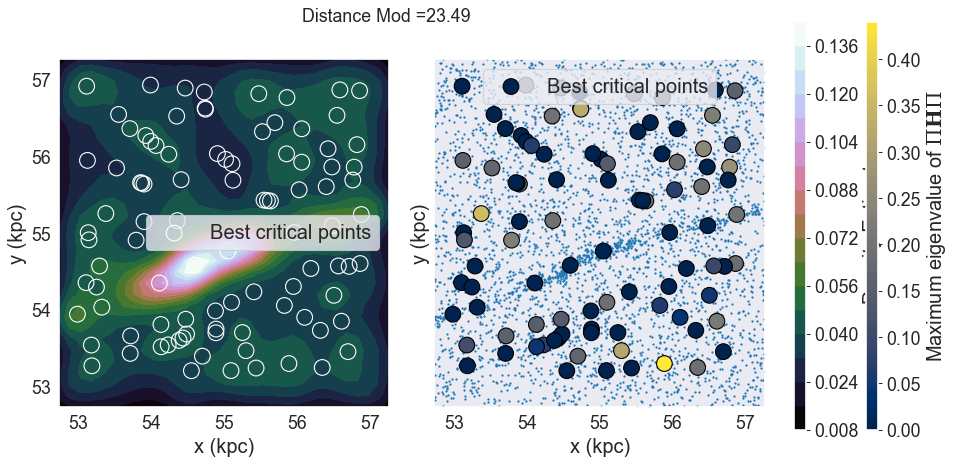

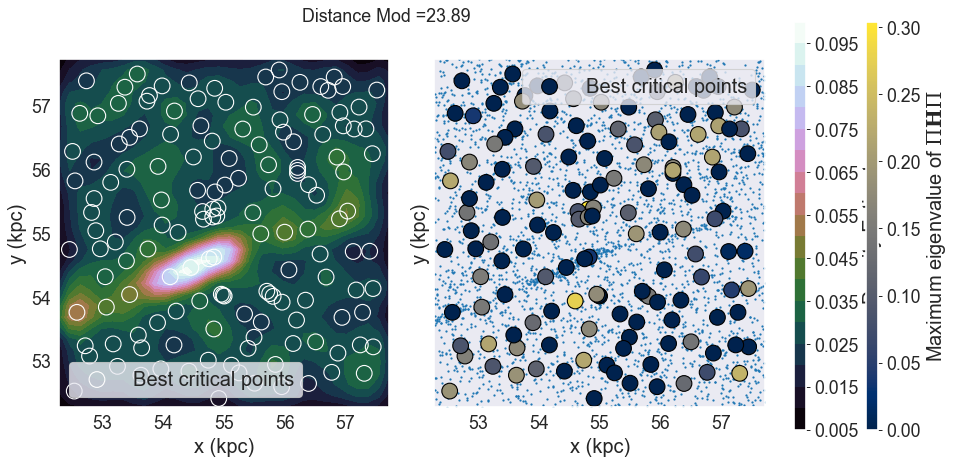

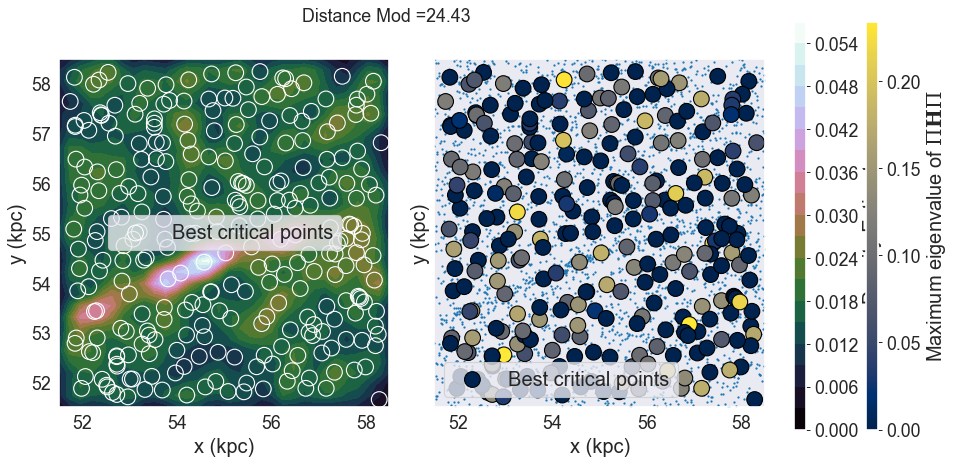

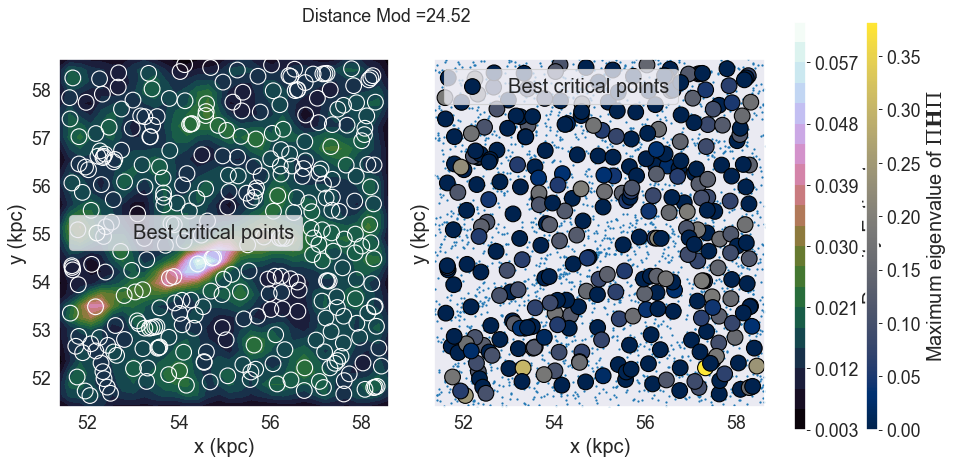

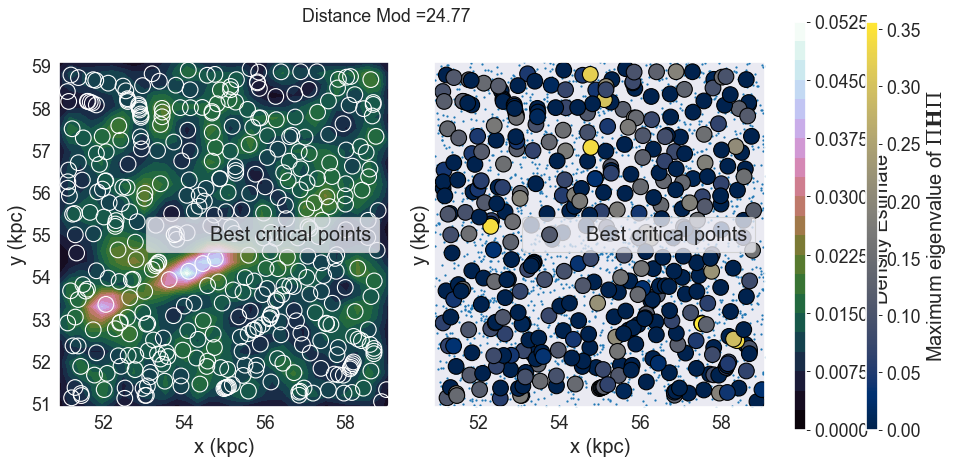

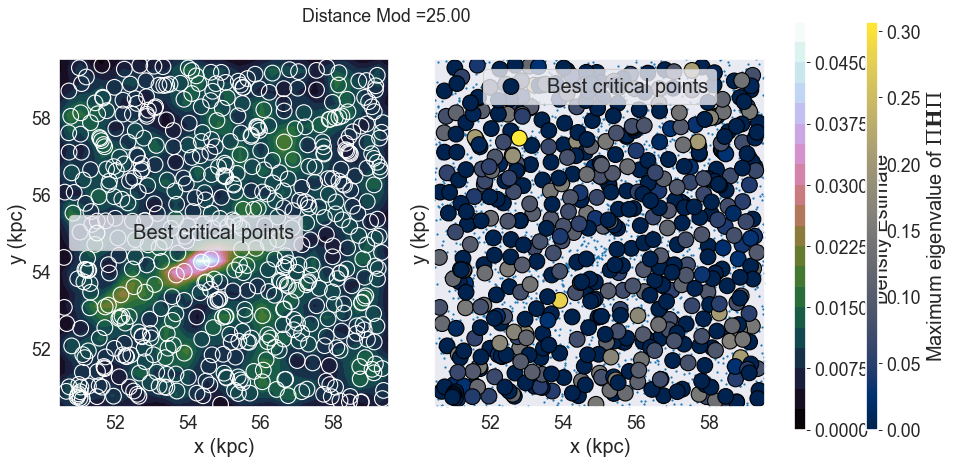

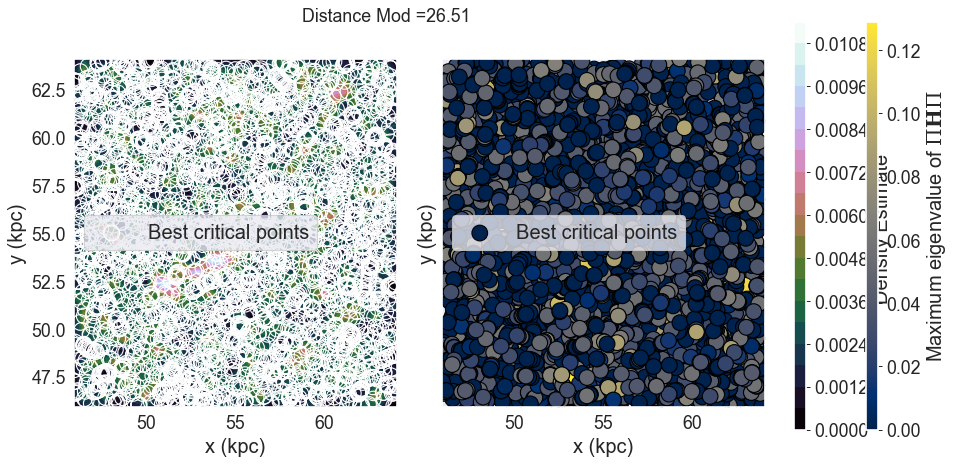

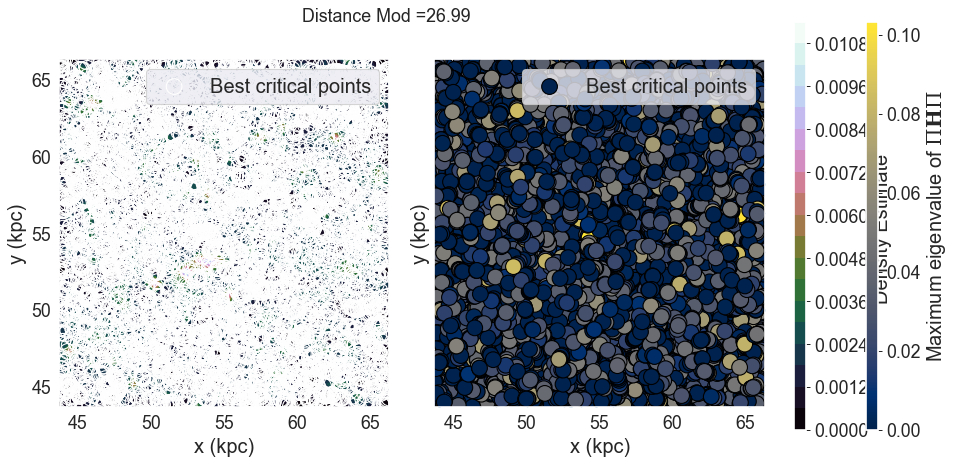

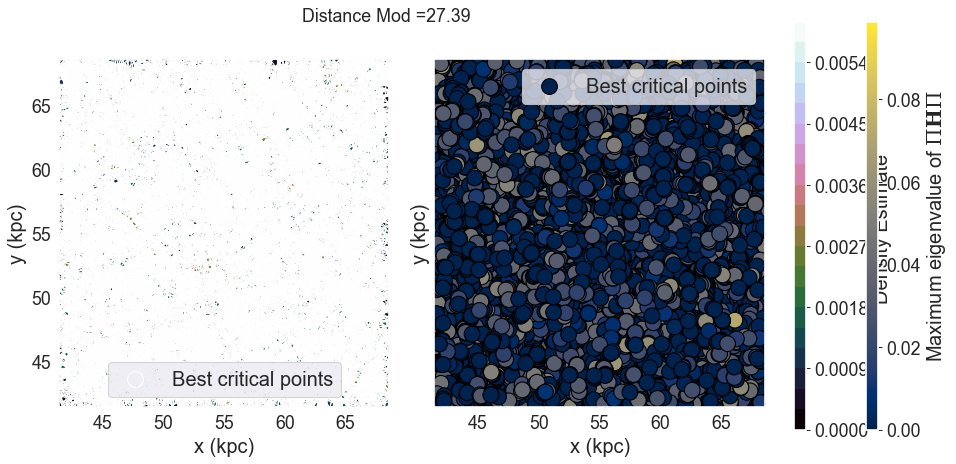

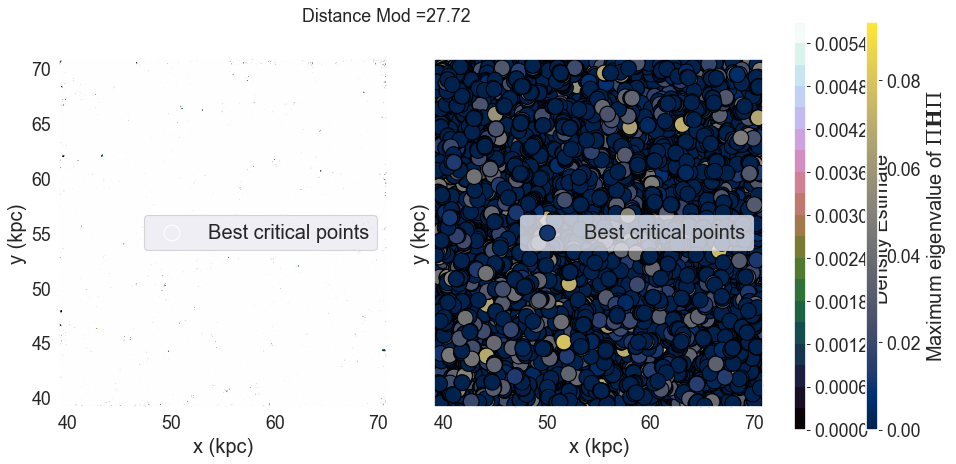

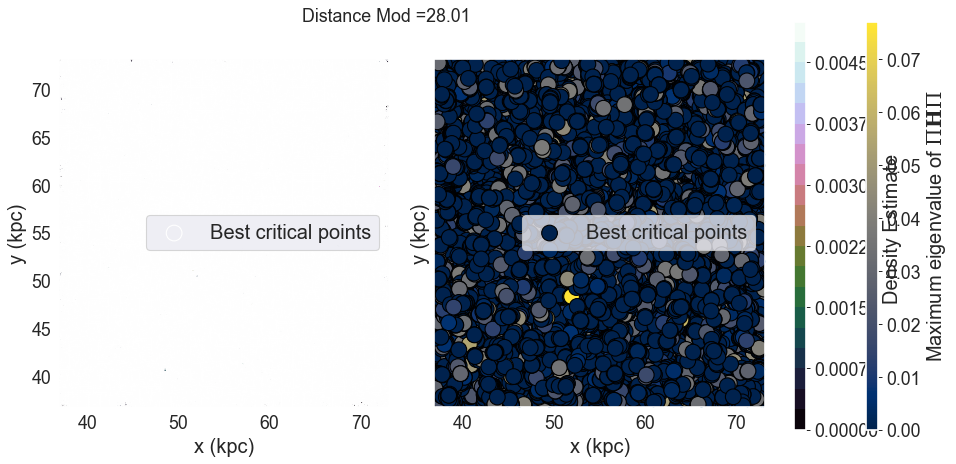

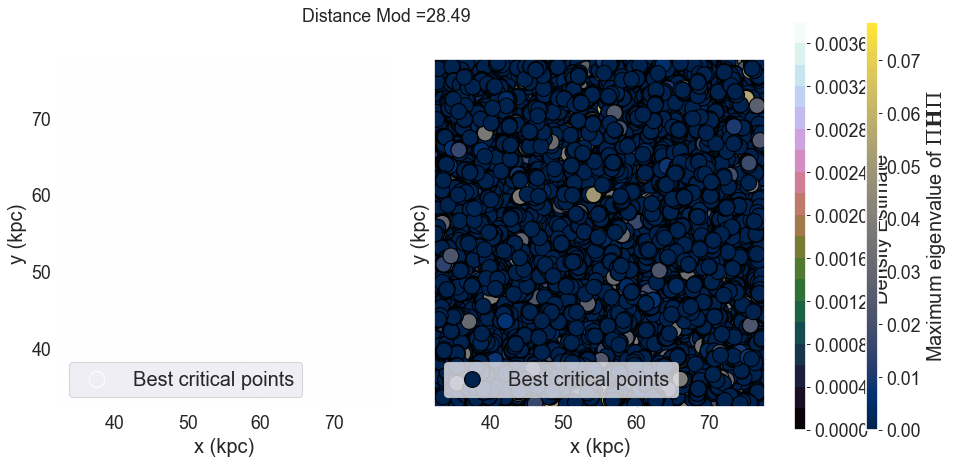

In [69]:
for key in images.keys():
    data=np.vstack(images[key]).T

    res=identify_gaps(data, bw=0.2, gridding_size = 32, N = 5)
    gap_res[k]=res
    
    fig, ax=plt.subplots(figsize=(10, 6), ncols=2, sharex=True, sharey=True)

    #density
    cax = fig.add_axes([1.01, 0.1, .015, 0.85])
    ctf = ax[0].contourf(res['grid'][0], res['grid'][1], res['density'], 20, cmap='cubehelix')
    _ =ax[0].scatter(res['critical_points'][res['idx_best_crits']][:,0], \
                         res['critical_points'][res['idx_best_crits']][:,1], 
                         s=200, c="None", edgecolor='white', label='Best critical points')
    cb = plt.colorbar(ctf, cax=cax)
    cb.ax.set_ylabel(r'Density Estimate ', fontsize=18)



    #hessian
    #cax = fig.add_axes([1.1, 0.1, .015, 0.85])
    #mp=ax[1].contourf(res['grid'][0], res['grid'][1], res['max_eig_vals_H_grid'], 20, cmap='RdBu_r',
    #             vmin = -(np.max(np.abs(res['max_eig_vals_H_grid']))), vmax=np.max(np.abs(res['max_eig_vals_H_grid'])))

    #ax[1].contour(res['grid'][0], res['grid'][1], res['density'], 20, cmap='copper', alpha=.5)
    #cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
    #cbar.ax.set_ylabel(r"Maximum eigenvalue of the Hessian $\mathbf{H}$", fontsize=18)
    #critsc =ax[1].scatter(res['critical_points'][res['idx_best_crits']][:,0], \
    #                     res['critical_points'][res['idx_best_crits']][:,1], 
    #                     s=200, c="None", edgecolor='b', label='Best critical points')
    cax = fig.add_axes([1.1, 0.1, .015, 0.85])
    ax[1].scatter(data[:, 0], data[:, -1], s=1)
    g =ax[1].scatter(res['critical_points'][res['idx_best_crits']][:,0], \
                         res['critical_points'][res['idx_best_crits']][:,1], 
                         s=200, c=res['max_eigval_PiHPi'], edgecolor='black',\
                     label='Best critical points', cmap='cividis')
    cbar=plt.colorbar(g, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel(r"Maximum eigenvalue of $\Pi \mathbf{H} \Pi$", fontsize=18)


    #phessianp
    #cax = fig.add_axes([1.2, 0.1, .015, 0.85])
    #pi = ax[2].contourf(res['grid'][0], res['grid'][1], res['max_eigval_PiHPi_resh'], 20, \
    #                    cmap='afmhot', extend='min')
    #ax[2].contourf(res['grid'][0], res['grid'][1], res['density'], 20, cmap='spring', alpha=.5)
    #critsc =ax[2].scatter(res['critical_points'][res['idx_best_crits']][:,0], \
    #                     res['critical_points'][res['idx_best_crits']][:,1], 
    #                     s=200, c="None", edgecolor='white', label='Best critical points')
    #cbar=plt.colorbar(pi, cax=cax, orientation='vertical')
    #cbar.ax.set_ylabel(r"Maximum eigenvalue of $\Pi \mathbf{H} \Pi$", fontsize=18)







    for a in ax:
        a.set_xlabel('x (kpc)', fontsize=18)
        a.set_ylabel('y (kpc)', fontsize=18)
        a.minorticks_on()
        a.legend()

    fig.suptitle('Distance Mod ={}'.format(key), fontsize=16)
    plt.tight_layout()

    plt.savefig(path_plot+'/example_detection_distant{}{}.jpeg'.format(key, mag_limit), bbox_inches='tight')

In [57]:
10**(27/5+1)*u.pc.to(u.Mpc)

2.5118864315095824

In [58]:
#try zooming in?